In [0]:
def load_data():
  dataset=pd.read_csv("dataset_hourly_search.csv")
  dataset.dropna(inplace=True)
  dataset['Open']=pd.to_numeric(dataset['Open'],downcast='float')
  dataset['High']=pd.to_numeric(dataset['High'],downcast='float')
  dataset['Low']=pd.to_numeric(dataset['Low'],downcast='float')
  dataset['Weighted Price']=pd.to_numeric(dataset['Weighted Price'],downcast='float')
  dataset.drop(columns='Timestamp',inplace=True)
  dataset.drop(columns='datetime',inplace=True)
  dataset.drop(columns='Unnamed: 0',inplace=True)
  num_steps=5
  dataset_multi = series_to_supervised(dataset, num_steps, 1)
  
  pd.set_option('display.max_columns', None)
  pd.set_option('display.width', None)
  pd.set_option('display.max_colwidth', -1)

  dataset_multi_np=dataset_multi.values
  nn_features=dataset_multi_np[:,0:dataset_multi_np.shape[1]-dataset.shape[1]]
  nn_output=dataset_multi_np[:,dataset_multi_np.shape[1]-2*dataset.shape[1]:]

  nn_labels=np.divide(nn_output[:,dataset.shape[1]+4],nn_output[:,4])>1
  print(dataset.shape[1]+4)
  #nn_output[:,[29,4]]
  return nn_features,nn_labels,nn_output[:,[4,dataset.shape[1]+4]]

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
def generate_rand_training(nn_features_scaled,nn_labels,num_training):
  #np.c_[nn_features_scaled, nn_labels]
  #select_array=np.random.choice(nn_features_scaled.shape[0], num_training, replace=False)
  concat_data=np.c_[nn_features_scaled, nn_labels]
  np.random.shuffle(concat_data)
  #print(concat_data)
  training, test = concat_data[:num_training,:], concat_data[num_training:,:]
  features_train = training[:,:nn_features_scaled.shape[1]]
  labels_train = training[:,-1]
  features_test =  test[:,:nn_features_scaled.shape[1]]
  labels_test = test[:,-1]
  #print(labels_train)
  #print(labels_test)
  return features_train,features_test,labels_train,labels_test

In [0]:
def generate_order_training(nn_features_scaled,nn_labels,num_training):
  features_train = nn_features_scaled[:num_training]
  features_test = nn_features_scaled[num_training:]
  labels_train = nn_labels[:num_training]
  labels_test = nn_labels[num_training:]
  #print(labels_train)
  #print(labels_test)
  return features_train,features_test,labels_train,labels_test

In [0]:
def fit_LSTM_multi(nn_features,nn_labels,num_steps,num_training):

  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()
  nn_features_scaled = sc.fit_transform(nn_features)
  feature_num=int(nn_features.shape[1]/num_steps)
  #nn_features_scaled=nn_features_scaled.reshape((nn_features_scaled.shape[0],num_steps,feature_num))
  #nn_labels=nn_labels.reshape((nn_labels.shape[0],1,nn_labels.shape[1]))
  features_train,features_test,labels_train,labels_test=generate_rand_training(nn_features_scaled,nn_labels,num_training)
  features_train=features_train.reshape((features_train.shape[0],num_steps,feature_num))
  features_test=features_test.reshape((features_test.shape[0],num_steps,feature_num))
  #features_train = nn_features_scaled[:num_training]
  #features_test = nn_features_scaled[num_training:]
  #labels_train = nn_labels[:num_training]
  #labels_test = nn_labels[num_training:]
  #Dependencies
  import keras
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.callbacks import History
  from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Flatten, Dropout
  # Neural network

  model = Sequential()
  model.add(LSTM(units=16, input_shape=(num_steps,feature_num)))
  model.add(Dropout(0.2))
  #model.add(LSTM(units=50, batch_input_shape=(8,1,23)))
  #model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  history = History()
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

  from sklearn.model_selection import KFold
  results = []
  kf = KFold(n_splits=10)
  for train_idx, val_idx in kf.split(features_train, labels_train):
      X_train = features_train[train_idx]
      y_train = labels_train[train_idx]
      X_val = features_train[val_idx]
      y_val = labels_train[val_idx]
      hist = model.fit(X_train, y_train, batch_size = 8, epochs = 100, validation_data = (X_val, y_val), verbose = 1, callbacks=[history])
      results.append(hist.history)

  print(results)

  score = model.evaluate(features_test, labels_test,verbose=1)
  print(score)
  return hist

In [0]:
def fit_NN_multi(nn_features,nn_labels,num_training):
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()
  nn_features_scaled = sc.fit_transform(nn_features)
  #nn_labels=nn_labels.reshape((nn_labels.shape[0],1,nn_labels.shape[1]))
  features_train,features_test,labels_train,labels_test=generate_rand_training(nn_features_scaled,nn_labels,num_training)
  #print(features_train.shape)
  #print(features_test.shape)
  #print(labels_train.shape)
  #print(labels_test.shape)  
  import keras
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.callbacks import History
  from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Flatten, Dropout
  # Neural network

  model = Sequential()
  model.add(Dense(16, input_dim=features_train.shape[1], activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  history = History()
  
  print(model.summary())

  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])  

  from sklearn.model_selection import KFold
  results = []
  kf = KFold(n_splits=2)
  for train_idx, val_idx in kf.split(features_train, labels_train):
      X_train = features_train[train_idx]
      y_train = labels_train[train_idx]
      X_val = features_train[val_idx]
      y_val = labels_train[val_idx]
      hist = model.fit(X_train, y_train, batch_size = 8, epochs = 100, validation_data = (X_val, y_val), verbose = 1, callbacks=[history])
      results.append(hist.history)

  #print(results)
  predictions = model.predict(features_test)
  score = model.evaluate(features_test, labels_test,verbose=1)
  print(score)

  prediction_dummy=predictions>0.5
  prediction_dummy=prediction_dummy.reshape(labels_test.shape)
  accuracy_score=np.equal(prediction_dummy,labels_test).sum()/prediction_dummy.shape[0]

  return score,prediction_dummy,labels_test

In [0]:
def rebal_model(nn_features,nn_labels):
  results=[]
  rebal_days=2160
  num_training=int(rebal_days/3*2)
  step_size=nn_features.shape[0]//rebal_days
  print("num_training: ",num_training)
  for i in range(step_size-1):
    print("running step: ",i)
    nn_features_step=nn_features[(i*rebal_days):(i*rebal_days+rebal_days),:]
    nn_labels_step=nn_labels[(i*rebal_days):(i*rebal_days+rebal_days)]
    #score=fit_NN_multi(nn_features_step,nn_labels_step,num_training)
    accuracy_score,predictions,prediction_dummy,labels_test=fit_rf(nn_features_step,nn_labels_step,num_training)
    results.append(accuracy_score)
    
  return results

In [0]:
import sys
def rebal_model_consecutive(nn_features,nn_labels):
  results=[]
  rebal_window=501
  num_training=500
  #num_training=
  #step_size=nn_features.shape[0]//rebal_days
  print("num_training: ",num_training)
  for i in range(nn_features.shape[0]-rebal_window):
    print("running step: ",i)
    nn_features_step=nn_features[i:i+rebal_window,:]
    nn_labels_step=nn_labels[i:i+rebal_window]
    accuracy_score,predictions,prediction_dummy,labels_test=fit_rf(nn_features_step,nn_labels_step,num_training)
    #score=fit_NN_multi(nn_features_step,nn_labels_step,num_training)
    results.append(accuracy_score)
    #sys.exit()
    print_accuracy(results)
  return results

In [0]:
def fit_rf(nn_features,nn_labels,num_training):
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()
  nn_features_scaled_rf = sc.fit_transform(nn_features)
  #features_train,features_test,labels_train,labels_test=generate_rand_training(nn_features_scaled_rf,nn_labels,num_training)
  features_train,features_test,labels_train,labels_test=generate_order_training(nn_features_scaled_rf,nn_labels,num_training)
  # Import the model we are using
  from sklearn.ensemble import RandomForestRegressor
  # Instantiate model with 1000 decision trees
  rf = RandomForestRegressor(n_estimators = 200, random_state = 42)
  # Train the model on training data
  rf.fit(features_train, labels_train);
  predictions = rf.predict(features_test)
  prediction_dummy=predictions>0.5
  #score=rf.score(predictions,labels_test)
  # Calculate the absolute errors
  #errors = abs(predictions - labels_test)
  # Print out the mean absolute error (mae)
  #print('Mean Absolute Error:', round(np.mean(errors), 2))
  accuracy_score=np.equal(prediction_dummy,labels_test).sum()/prediction_dummy.shape[0]
  print('prediction accuracy',accuracy_score)
  return accuracy_score,predictions,prediction_dummy,labels_test

In [0]:
def print_accuracy(return_array):
  #print(return_array)
  roll_sum=0
  for i in range(len(return_array)):
    roll_sum=roll_sum+return_array[i]
  print('rolling accuracy', roll_sum/len(return_array))

In [0]:
import pandas as pd
import numpy as np
nn_features,nn_labels,nn_output=load_data()
print(nn_features.shape)
return_array=rebal_model_consecutive(nn_features,nn_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


29
(9553, 125)
num_training:  500
running step:  0
prediction accuracy 1.0
rolling accuracy 1.0
running step:  1
prediction accuracy 1.0
rolling accuracy 1.0
running step:  2
prediction accuracy 1.0
rolling accuracy 1.0
running step:  3
prediction accuracy 1.0
rolling accuracy 1.0
running step:  4
prediction accuracy 1.0
rolling accuracy 1.0
running step:  5
prediction accuracy 0.0
rolling accuracy 0.8333333333333334
running step:  6
prediction accuracy 1.0
rolling accuracy 0.8571428571428571
running step:  7
prediction accuracy 1.0
rolling accuracy 0.875
running step:  8
prediction accuracy 1.0
rolling accuracy 0.8888888888888888
running step:  9
prediction accuracy 0.0
rolling accuracy 0.8
running step:  10
prediction accuracy 0.0
rolling accuracy 0.7272727272727273
running step:  11
prediction accuracy 1.0
rolling accuracy 0.75
running step:  12
prediction accuracy 0.0
rolling accuracy 0.6923076923076923
running step:  13
prediction accuracy 1.0
rolling accuracy 0.7142857142857143
r

In [0]:
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()
  nn_features_scaled = sc.fit_transform(nn_features)
  #nn_labels=nn_labels.reshape((nn_labels.shape[0],1,nn_labels.shape[1]))
  features_train,features_test,labels_train,labels_test=generate_rand_training(nn_features_scaled,nn_labels,num_training)
  #print(features_train.shape)
  #print(features_test.shape)
  #print(labels_train.shape)
  #print(labels_test.shape)  
  import keras
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.callbacks import History
  from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional, Flatten, Dropout
  # Neural network

  model = Sequential()
  model.add(Dense(16, input_dim=features_train.shape[1], activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(1,activation='sigmoid'))
  history = History()
  
  print(model.summary())

  model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])  

  from sklearn.model_selection import KFold
  results = []
  kf = KFold(n_splits=5)
  for train_idx, val_idx in kf.split(features_train, labels_train):
      X_train = features_train[train_idx]
      y_train = labels_train[train_idx]
      X_val = features_train[val_idx]
      y_val = labels_train[val_idx]
      hist = model.fit(X_train, y_train, batch_size = 8, epochs = 100, validation_data = (X_val, y_val), verbose = 1, callbacks=[history])
      results.append(hist.history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                2016      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________
None
Train on 4800 samples, validate on 1200 samples
Epoch 1/100
4800/4800 [==============================] - 1s 185us/step - loss: 0.6978 - accuracy: 0.5092 - val_loss: 0.6936 - val_accuracy: 0.5283
Epoch 2/100
4800/4800 [==============================] - 1s 166us/step - loss: 0.6923 - accuracy: 0.5340 - val_loss: 0.6935 - val_accuracy: 0.5317
Epoch 3/100
4800/4800 [============

In [0]:
  predictions = model.predict(features_test)

In [0]:
  prediction_dummy=predictions>0.5
  prediction_dummy=prediction_dummy.reshape(labels_test.shape)
  accuracy_score=np.equal(prediction_dummy,labels_test).sum()/prediction_dummy.shape[0]

In [0]:
import pandas as pd
import numpy as np

In [0]:
nn_features,nn_labels=load_data()

29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


ValueError: ignored

In [0]:
import pandas as pd
import numpy as np
nn_features,nn_labels=load_data()
#return_array=fit_NN_multi(nn_features,nn_labels,int(nn_features.shape[0]//5*4))
print(return_array)
#return_array=rebal_model_consecutive(nn_features,nn_labels)

FileNotFoundError: ignored

In [0]:
import pandas as pd
import numpy as np
#nn_features,nn_labels=load_data()
num_steps=5
return_array=fit_LSTM_multi(nn_features,nn_labels,num_steps,int(nn_features.shape[0]//5*4))
#return_array=rebal_model_consecutive(nn_features,nn_labels)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16)                2752      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 2,769
Trainable params: 2,769
Non-trainable params: 0
_________________________________________________________________
Train on 6876 samples, validate on 764 samples
Epoch 1/100
6876/6876 [==============================] - 6s 888us/step - loss: 0.6874 - acc: 0.5352 - val_loss: 0.6623 - val_acc: 0.6230
Epoch 2/100
6876/6876 [==============================] - 5s 717us/step - loss: 0.6600 - acc: 0.6037 - val_loss: 0.6348 - val_acc: 0.6571
Epoch 3/100
6876/6876 [==============================] - 5s 7

In [0]:
print(return_array)
roll_sum=0
for i in range(len(return_array)):
  roll_sum=roll_sum+return_array[i][1]
print(roll_sum/len(return_array))

[[3.8195297718048096, 0.5833333373069763], [3.564375909169515, 0.6666666547457377], [4.290429464975992, 0.5833333273728688], [3.588313515981038, 0.6833333214124043], [4.506832472483317, 0.5666666547457377], [4.926980622609457, 0.5]]
0.5972222159306209


In [0]:
nn_features,nn_labels,nn_output=load_data()

29


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


In [0]:
import pandas as pd
import numpy as np

In [0]:
num_training=6112 
accuracy_score,predictions,prediction_dummy,labels_test=fit_rf(nn_features,nn_labels,num_training)

prediction accuracy 0.5379250217959896


In [0]:
def gen_long_only_port(prediction_dummy,predictions,nn_output,num_training,labels_test):
  #long only
  port_value=[]
  market_value=[]
  port_curr=1000
  record=[]
  for i in range(prediction_dummy.shape[0]):

    if predictions[i]>.5:
      return_ratio=(nn_output[i+num_training,1]-nn_output[i+num_training,0])/nn_output[i+num_training,0]
      port_curr=port_curr*(1+return_ratio)
    port_value.append(port_curr)
    curr_record=[nn_output[i+num_training,0],nn_output[i+num_training,1],labels_test[i],prediction_dummy[i],port_curr]
    record.append(curr_record)
    print(curr_record)
  print("portfolio return", (curr_record[4]-1000)/1000)
  print("market return", (curr_record[1]-record[0][1])/record[0][1]) 
  return(record)



In [0]:
def gen_ls_port(prediction_dummy,predictions,nn_output,num_training,labels_test):
  #long only
  port_value=[]
  market_value=[]
  port_curr=1000
  record=[]
  for i in range(prediction_dummy.shape[0]):
    #if prediction_dummy[i]:
    if predictions[i]>.5:
      return_ratio=(nn_output[i+num_training,1]-nn_output[i+num_training,0])/nn_output[i+num_training,0]
      port_curr=port_curr*(1+return_ratio)
    elif predictions[i]<.5:
      return_ratio=-(nn_output[i+num_training,1]-nn_output[i+num_training,0])/nn_output[i+num_training,0]
      port_curr=port_curr*(1+return_ratio)
    port_value.append(port_curr)
    curr_record=[nn_output[i+num_training,0],nn_output[i+num_training,1],nn_labels[i],prediction_dummy[i],port_curr]
    record.append(curr_record)
    print(curr_record)
  print("portfolio return", (curr_record[4]-1000)/1000)
  print("market return", (curr_record[1]-record[0][1])/record[0][1]) 
  return(record)


In [0]:
ls_record=gen_ls_port(prediction_dummy,predictions,nn_output,num_training,labels_test)

[10317.1, 10299.9, False, False, 1001.6671351445658]
[10299.9, 10225.1, False, False, 1008.9414486533195]
[10225.1, 10229.8, True, True, 1009.4052118251877]
[10229.8, 10211.4, False, False, 1011.2207953065443]
[10211.4, 10266.5, True, True, 1016.6772719719762]
[10266.5, 10300.8, True, False, 1013.2805904905913]
[10300.8, 10295.0, True, False, 1013.8511313636153]
[10295.0, 10362.1, True, False, 1007.2431264180593]
[10362.1, 10333.0, False, False, 1010.0717784267028]
[10333.0, 10322.8, True, False, 1011.0688491844646]
[10322.8, 10307.0, False, True, 1009.5213148122872]
[10307.0, 10309.2, True, True, 1009.7367942818311]
[10309.2, 10292.1, True, False, 1011.4116574314662]
[10292.1, 10307.6, False, True, 1012.934852959122]
[10307.6, 10303.8, False, False, 1013.3082815400958]
[10303.8, 10335.0, True, False, 1010.2399748586722]
[10335.0, 10325.1, False, False, 1011.2076938476515]
[10325.1, 10308.4, False, False, 1012.8432391195865]
[10308.4, 10316.6, True, True, 1013.6489232762725]
[10316.6, 

In [0]:
record=gen_long_only_port(prediction_dummy,predictions,nn_output,num_training,labels_test)

[10317.1, 10299.9, False, False, 1000]
[10299.9, 10225.1, False, False, 1000]
[10225.1, 10229.8, True, True, 1000.4596532063255]
[10229.8, 10211.4, False, False, 1000.4596532063255]
[10211.4, 10266.5, True, True, 1005.8580635018451]
[10266.5, 10300.8, True, False, 1005.8580635018451]
[10300.8, 10295.0, False, False, 1005.8580635018451]
[10295.0, 10362.1, True, False, 1005.8580635018451]
[10362.1, 10333.0, False, False, 1005.8580635018451]
[10333.0, 10322.8, False, False, 1005.8580635018451]
[10322.8, 10307.0, False, True, 1004.3185047190218]
[10307.0, 10309.2, True, True, 1004.5328736634657]
[10309.2, 10292.1, False, False, 1004.5328736634657]
[10292.1, 10307.6, True, True, 1006.045709677669]
[10307.6, 10303.8, False, False, 1006.045709677669]
[10303.8, 10335.0, True, False, 1006.045709677669]
[10335.0, 10325.1, False, False, 1006.045709677669]
[10325.1, 10308.4, False, False, 1006.045709677669]
[10308.4, 10316.6, True, True, 1006.8459866187421]
[10316.6, 10301.9, False, True, 1005.411

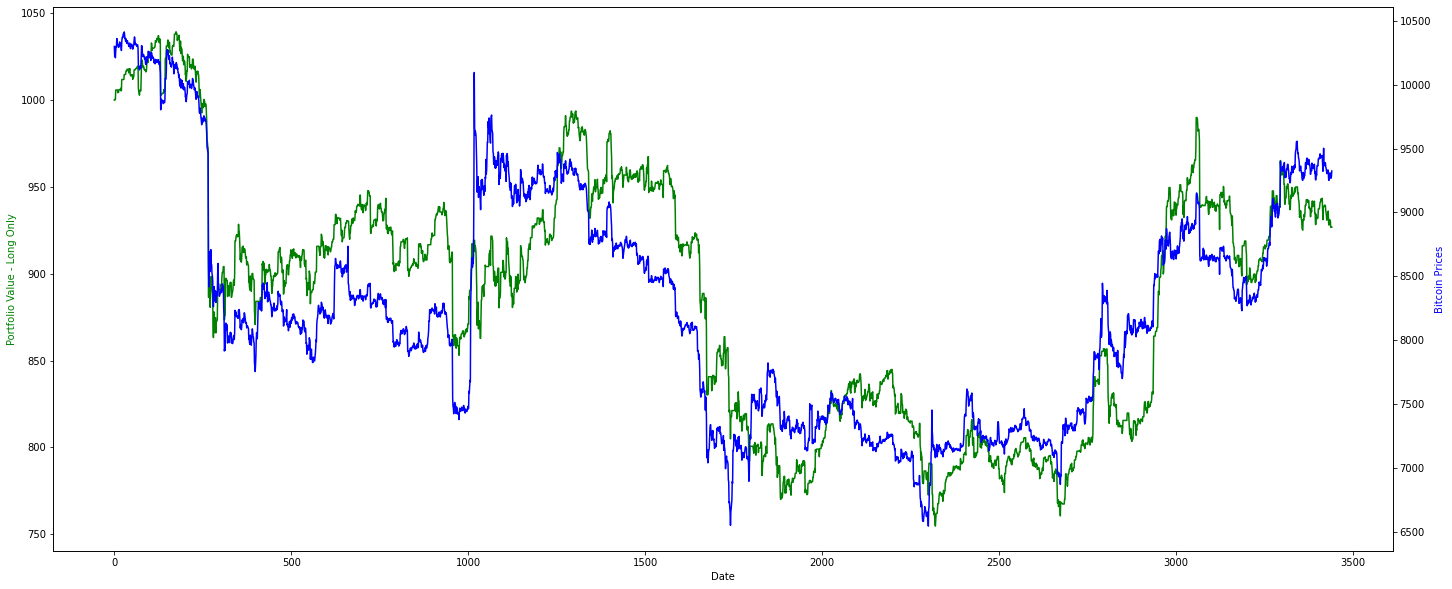

In [0]:
#goog_monthly
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

#ax1.plot(goog_daily.index, goog_monthly['bitcoin'], 'g-')
#ax2.plot(goog_monthly.index, goog_monthly['cryptocurrency'], 'b-')


ax1.plot( np.array(record)[:,4], 'g-')
ax2.plot(np.array(record)[:,1], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value - Long Only', color='g')
ax2.set_ylabel('Bitcoin Prices', color='b')

plt.show()
plt.rcParams['figure.figsize'] = 24,10

In [0]:
fig.savefig("lo port")

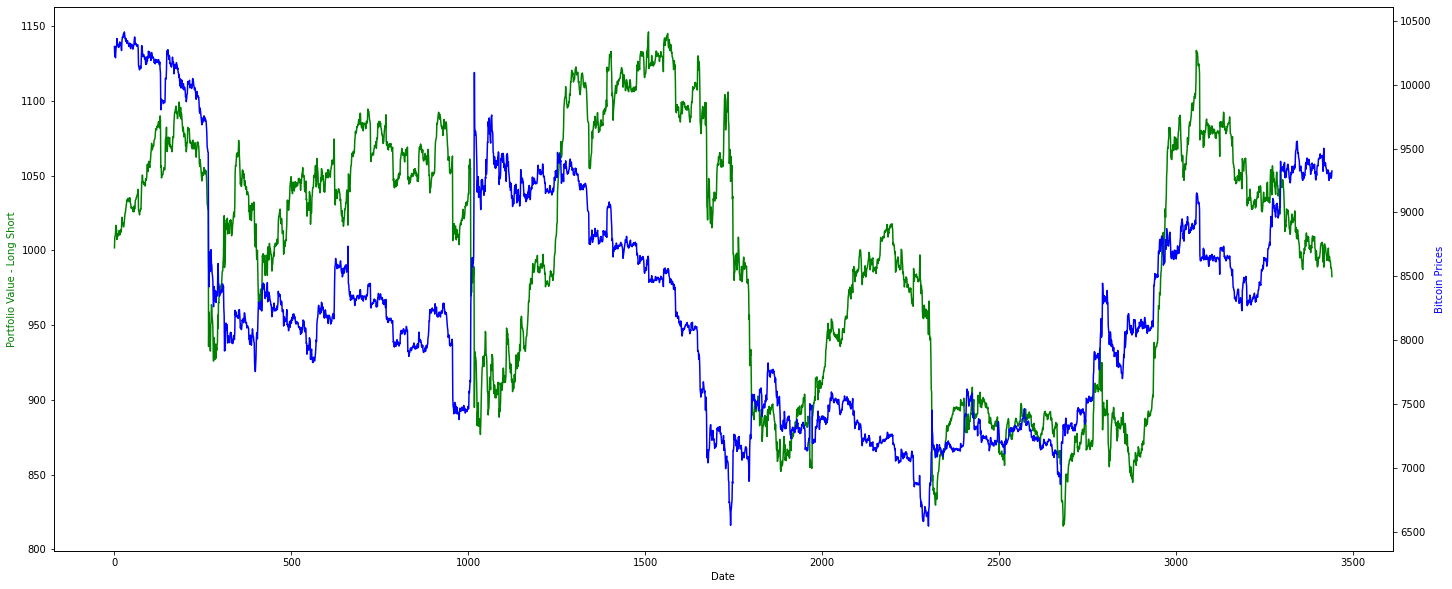

In [0]:
#goog_monthly
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

#ax1.plot(goog_daily.index, goog_monthly['bitcoin'], 'g-')
#ax2.plot(goog_monthly.index, goog_monthly['cryptocurrency'], 'b-')


ax1.plot( np.array(ls_record)[:,4], 'g-')
ax2.plot(np.array(ls_record)[:,1], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value - Long Short', color='g')
ax2.set_ylabel('Bitcoin Prices', color='b')

plt.show()
plt.rcParams['figure.figsize'] = 24,10

In [0]:

fig.savefig("ls port")

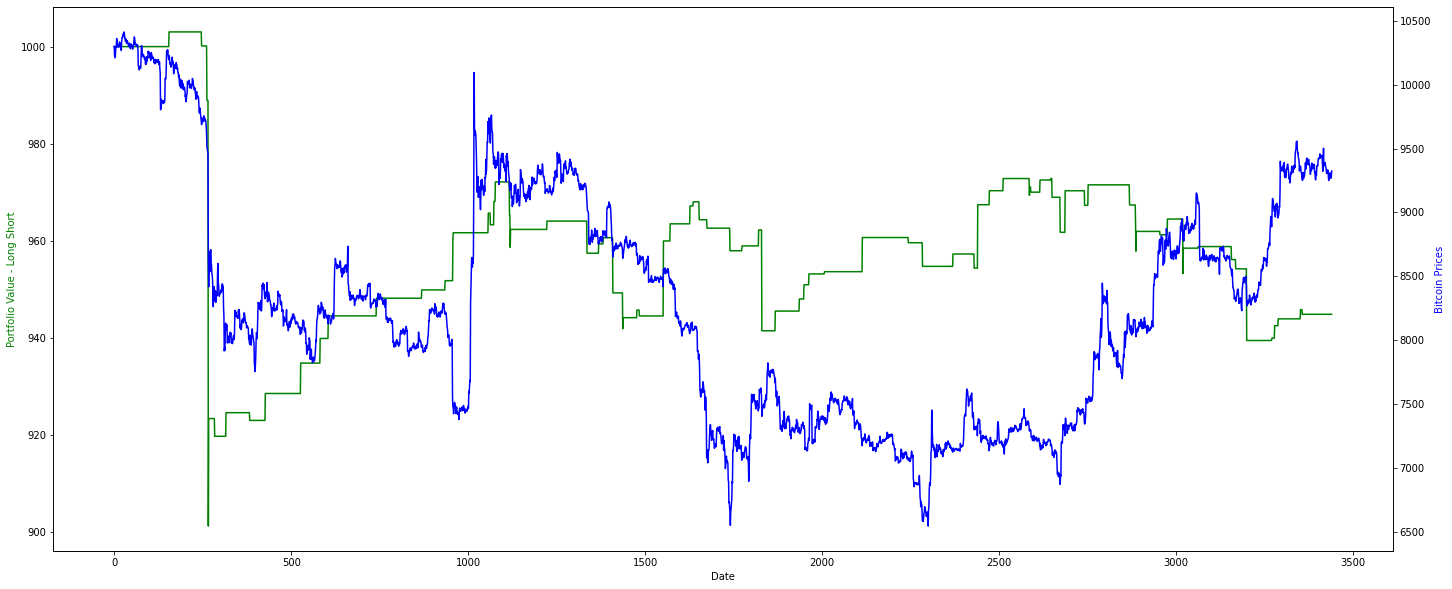

In [0]:
#goog_monthly
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

#ax1.plot(goog_daily.index, goog_monthly['bitcoin'], 'g-')
#ax2.plot(goog_monthly.index, goog_monthly['cryptocurrency'], 'b-')


ax1.plot( np.array(ls_record)[:,4], 'g-')
ax2.plot(np.array(ls_record)[:,1], 'b-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value - Long Short', color='g')
ax2.set_ylabel('Bitcoin Prices', color='b')

plt.show()
plt.rcParams['figure.figsize'] = 24,10

In [0]:
prediction_dummy

array([False,  True,  True, ...,  True,  True,  True])

In [0]:
nn_output[:,4]

array([3694.5, 3682.8, 3676.9, ..., 9267.5, 9268.1, 9281. ])

In [0]:
pd.DataFrame(nn_features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124
0,3687.800049,3692.699951,3663.300049,3682.409912,3679.1,3739.785714,3766.738095,3754.488461,3740.791135,-13.697326,39.094945,3844.927986,3688.548204,3689.929177,3691.9,3750.0,3748.9,3755.8,3770.5,0.996533,0.981093,0.981381,0.979578,0.975759,4.647366,3678.899902,3682.600098,3660.699951,3672.550049,3670.5,3723.814286,3759.528571,3746.864792,3729.695910,-17.168882,41.589118,3842.706808,3676.350335,3676.976392,3679.1,3691.9,3750.0,3748.9,3755.8,0.997662,0.994204,0.978800,0.979087,0.977288,4.647366,3670.500000,3686.300049,3659.600098,3667.610107,3685.9,3711.728571,3754.385714,3741.421868,3722.810416,-18.611453,37.888904,3830.163522,3678.607906,3682.925464,3670.5,3679.1,3691.9,3750.0,3748.9,1.004196,1.001848,0.998375,0.982907,0.983195,4.647366,3686.300049,3698.899902,3681.500000,3690.820068,3691.9,3702.600000,3750.566667,3737.066789,3717.967079,-19.099709,32.865838,3816.298343,3684.834990,3688.908488,3685.9,3670.5,3679.1,3691.9,3750.0,1.001628,1.005830,1.003479,1.000000,0.984507,4.647366,3690.899902,3704.899902,3683.199951,3689.750000,3694.5,3694.828571,3746.495238,3733.374562,3714.300461,-19.074101,25.755693,3798.006624,3694.983852,3692.636163,3691.9,3685.9,3670.5,3679.1,3691.9,1.000704,1.002333,1.006539,1.004186,1.000704,4.647366
1,3678.899902,3682.600098,3660.699951,3672.550049,3670.5,3723.814286,3759.528571,3746.864792,3729.695910,-17.168882,41.589118,3842.706808,3676.350335,3676.976392,3679.1,3691.9,3750.0,3748.9,3755.8,0.997662,0.994204,0.978800,0.979087,0.977288,4.647366,3670.500000,3686.300049,3659.600098,3667.610107,3685.9,3711.728571,3754.385714,3741.421868,3722.810416,-18.611453,37.888904,3830.163522,3678.607906,3682.925464,3670.5,3679.1,3691.9,3750.0,3748.9,1.004196,1.001848,0.998375,0.982907,0.983195,4.647366,3686.300049,3698.899902,3681.500000,3690.820068,3691.9,3702.600000,3750.566667,3737.066789,3717.967079,-19.099709,32.865838,3816.298343,3684.834990,3688.908488,3685.9,3670.5,3679.1,3691.9,3750.0,1.001628,1.005830,1.003479,1.000000,0.984507,4.647366,3690.899902,3704.899902,3683.199951,3689.750000,3694.5,3694.828571,3746.495238,3733.374562,3714.300461,-19.074101,25.755693,3798.006624,3694.983852,3692.636163,3691.9,3685.9,3670.5,3679.1,3691.9,1.000704,1.002333,1.006539,1.004186,1.000704,4.647366,3690.600098,3694.399902,3677.100098,3683.649902,3682.8,3685.228571,3741.533333,3729.042611,3709.390444,-19.652167,8.522659,3758.578651,3724.488016,3686.078721,3694.5,3691.9,3685.9,3670.5,3679.1,0.996833,0.997535,0.999159,1.003351,1.001006,4.647366
2,3670.500000,3686.300049,3659.600098,3667.610107,3685.9,3711.728571,3754.385714,3741.421868,3722.810416,-18.611453,37.888904,3830.163522,3678.607906,3682.925464,3670.5,3679.1,3691.9,3750.0,3748.9,1.004196,1.001848,0.998375,0.982907,0.983195,4.647366,3686.300049,3698.899902,3681.500000,3690.820068,3691.9,3702.600000,3750.566667,3737.066789,3717.967079,-19.099709,32.865838,3816.298343,3684.834990,3688.908488,3685.9,3670.5,3679.1,3691.9,3750.0,1.001628,1.005830,1.003479,1.000000,0.984507,4.647366,3690.899902,3704.899902,3683.199951,3689.750000,3694.5,3694.828571,3746.495238,3733.374562,3714.300461,-19.074101,25.755693,3798.006624,3694.983852,3692.636163,3691.9,3685.9,3670.5,3679.1,3691.9,1.000704,1.002333,1.006539,1.004186,1.000704,4.647366,3690.600098,3694.399902,3677.100098,3683.649902,3682.8,3685.228571,3741.533333,3729.042611,3709.390444,-19.652167,8.522659,3758.578651,3724.488016,3686.078721,3694.5,3691.9,3685.9,3670.5,3679.1,0.996833,0.997535,0.999159,1.003351,1.001006,4.647366,3682.800049,3687.800049,3668.800049,3678.379883,3676.9,3683.085714,3736.628571,3724.627479,3704.336353,-20.291126,8.451

In [0]:
  dataset=pd.read_csv("dataset_hourly_search.csv")
  dataset.dropna(inplace=True)
  dataset['Open']=pd.to_numeric(dataset['Open'],downcast='float')
  dataset['High']=pd.to_numeric(dataset['High'],downcast='float')
  dataset['Low']=pd.to_numeric(dataset['Low'],downcast='float')
  dataset['Weighted Price']=pd.to_numeric(dataset['Weighted Price'],downcast='float')
  dataset.drop(columns='Timestamp',inplace=True)
  dataset.drop(columns='datetime',inplace=True)
  dataset.drop(columns='Unnamed: 0',inplace=True)
  num_steps=5
  dataset_multi = series_to_supervised(dataset, num_steps, 1)

In [0]:
dataset_multi.head(30)

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),var11(t-5),var12(t-5),var13(t-5),var14(t-5),var15(t-5),var16(t-5),var17(t-5),var18(t-5),var19(t-5),var20(t-5),var21(t-5),var22(t-5),var23(t-5),var24(t-5),var25(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var16(t-4),var17(t-4),var18(t-4),var19(t-4),var20(t-4),var21(t-4),var22(t-4),var23(t-4),var24(t-4),var25(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var16(t-3),var17(t-3),var18(t-3),var19(t-3),var20(t-3),var21(t-3),var22(t-3),var23(t-3),var24(t-3),var25(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var20(t-2),var21(t-2),var22(t-2),var23(t-2),var24(t-2),var25(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t)
25,3687.800049,3692.699951,3663.300049,3682.409912,3679.1,3739.785714,3766.738095,3754.488461,3740.791135,-13.697326,39.094945,3844.927986,3688.548204,3689.929177,3691.9,3750.0,3748.9,3755.8,3770.5,0.996533,0.981093,0.981381,0.979578,0.975759,4.647366,3678.899902,3682.600098,3660.699951,3672.550049,3670.5,3723.814286,3759.528571,3746.864792,3729.695910,-17.168882,41.589118,3842.706808,3676.350335,3676.976392,3679.1,3691.9,3750.0,3748.9,3755.8,0.997662,0.994204,0.978800,0.979087,0.977288,4.647366,3670.500000,3686.300049,3659.600098,3667.610107,3685.9,3711.728571,3754.385714,3741.421868,3722.810416,-18.611453,37.888904,3830.163522,3678.607906,3682.925464,3670.5,3679.1,3691.9,3750.0,3748.9,1.004196,1.001848,0.998375,0.982907,0.983195,4.647366,3686.300049,3698.899902,3681.500000,3690.820068,3691.9,3702.600000,3750.566667,3737.066789,3717.967079,-19.099709,32.865838,3816.298343,3684.834990,3688.908488,3685.9,3670.5,3679.1,3691.9,3750.0,1.001628,1.005830,1.003479,1.000000,0.984507,4.647366,3690.899902,3704.899902,3683.199951,3689.750000,3694.5,3694.828571,3746.495238,3733.374562,3714.300461,-19.074101,25.755693,3798.006624,3694.983852,3692.636163,3691.9,3685.9,3670.5,3679.1,3691.9,1.000704,1.002333,1.006539,1.004186,1.000704,4.647366,3690.600098,3694.399902,3677.100098,3683.649902,3682.8,3685.228571,3741.533333,3729.042611,3709.390444,-19.652167,8.522659,3758.578651,3724.488016,3686.078721,3694.5,3691.9,3685.9,3670.5,3679.1,0.996833,0.997535,0.999159,1.003351,1.001006,4.647366
26,3678.899902,3682.600098,3660.699951,3672.550049,3670.5,3723.814286,3759.528571,3746.864792,3729.695910,-17.168882,41.589118,3842.706808,3676.350335,3676.976392,3679.1,3691.9,3750.0,3748.9,3755.8,0.997662,0.994204,0.978800,0.979087,0.977288,4.647366,3670.500000,3686.300049,3659.600098,3667.610107,3685.9,3711.728571,3754.385714,3741.421868,3722.810416,-18.611453,37.888904,3830.163522,3678.607906,3682.925464,3670.5,3679.1,3691.9,3750.0,3748.9,1.004196,1.001848,0.998375,0.982907,0.983195,4.647366,3686.300049,3698.899902,3681.500000,3690.820068,3691.9,3702.600000,3750.566667,3737.066789,3717.967079,-19.099709,32.865838,3816.298343,3684.834990,3688.908488,3685.9,3670.5,3679.1,3691.9,3750.0,1.001628,1.005830,1.003479,1.000000,0.984507,4.647366,3690.899902,3704.899902,3683.199951,3689.750000,3694.5,3694.828571,3746.495238,3733.374562,3714.300461,-19.074101,25.755693,3798.006624,3694.983852,3692.636163,3691.9,3685.9,3670.5,3679.1,3691.9,1.000704,1.0

In [0]:
def plot_loss(hist):
  import matplotlib.pyplot as plt
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()

In [0]:
predictions.shape

(390,)

In [0]:
print (get_accuracy(X_test_orig,y_test,predictions))

NameError: name 'get_accuracy' is not defined

In [0]:

# Import tools needed for visualization
from sklearn.tree import export_graphviz
#import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
feature_list = list(dataset.columns)
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

ModuleNotFoundError: No module named 'pydot'

In [0]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(random_state=1)
model.fit(nn_features[:600], y_train)
model.score(x_test,y_test)

NameError: name 'feature_list' is not defined

In [0]:
files.download('tree.png') 

In [0]:
nn_features[:600]

NameError: ignored

In [0]:
nn_features

NameError: ignored